# HSCT survival: clustering

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import power_transform

import configuration as config

pd.set_option('display.max_rows', 500)

# Dataset definition file
datasets_definitions_file=f'{config.DATA_PATH}/processed/02.1-dataset_definitions.pkl'

# Feature type definitions file
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'
train_tree=True
train_nn=False

## 1. Load metadata

In [2]:
# Load dataset definitions
with open(datasets_definitions_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

Nominal one-hot/ordinal encoded, NANs encoded: ../data/processed/02.1-no-multicollinearity_one_hot_ordinal_nan_encoded_data_df.parquet
Nominal one-hot/ordinal encoded, NANs imputed: ../data/processed/02.1-no-multicollinearity_one_hot_ordinal_nan_imputed_data_df.parquet
All ordinal encoded, NAN encoded: ../data/processed/02.1-no-multicollinearity_ordinal_all_nan_encoded_data_df.parquet
All ordinal encoded, NAN imputed: ../data/processed/02.1-no-multicollinearity_ordinal_all_nan_imputed_data_df.parquet
Binary target encoded: ../data/processed/02.1-binary_target_encoded_data_df
Continuous target encoded: ../data/processed/02.1-continuous_target_encoded_data_df

Interval:

['donor_age', 'age_at_hct']
Ordinal:

['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', '

## 2. Clustering

### 2.1. Gradient boosting

#### 2.1.1. Dataset evaluation

In [3]:
if train_tree == True:

    cross_val_results={
        'Dataset':[],
        'Mean log-loss': [],
        'Standard deviation log-loss': []
    }

    # Define cross-validation strategy
    cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        data_df=pd.read_parquet(data_file)

        # Drop the unencoded race_group
        data_df.drop('race_group', axis=1, inplace=True)

        # Remove the labels
        labels_df=data_df[['efs', 'efs_time']].copy()
        features_df=data_df.drop(['efs', 'efs_time'], axis=1)

        scores=cross_val_score(
            GradientBoostingClassifier(random_state=315),
            features_df,
            labels_df['efs'],
            cv=cv
        )

        scores_mean=np.array(scores).mean()
        scores_std=np.array(scores).std()
        cross_val_results['Dataset'].append(dataset)
        cross_val_results['Mean log-loss'].append(scores_mean)
        cross_val_results['Standard deviation log-loss'].append(scores_std)

        print(f'{dataset} log-loss: {np.array(scores).mean():.3f} +/- {np.array(scores).std():.3f}')

Nominal one-hot/ordinal encoded, NANs encoded log-loss: 0.678 +/- 0.004
Nominal one-hot/ordinal encoded, NANs imputed log-loss: 0.678 +/- 0.004
All ordinal encoded, NAN encoded log-loss: 0.679 +/- 0.004
All ordinal encoded, NAN imputed log-loss: 0.678 +/- 0.005
Binary target encoded log-loss: 0.681 +/- 0.004
Continuous target encoded log-loss: 0.680 +/- 0.003



Nominal one-hot/ordinal encoded, NANs encoded



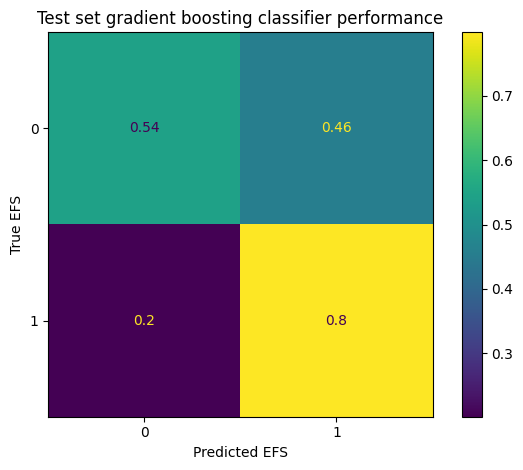

Precision: 0.673
Recall: 0.799


Nominal one-hot/ordinal encoded, NANs imputed



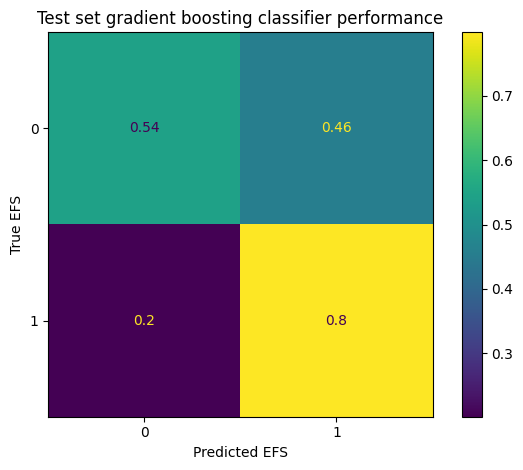

Precision: 0.673
Recall: 0.799


All ordinal encoded, NAN encoded



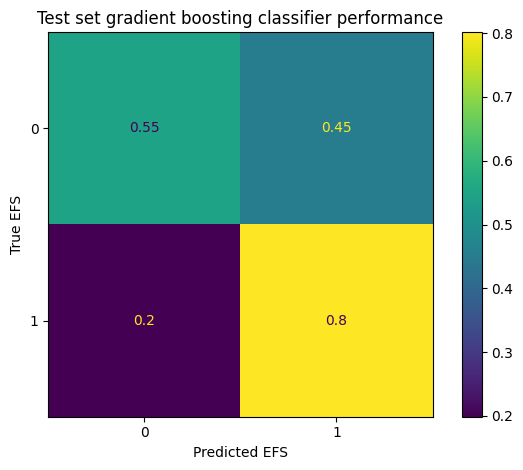

Precision: 0.675
Recall: 0.801


All ordinal encoded, NAN imputed



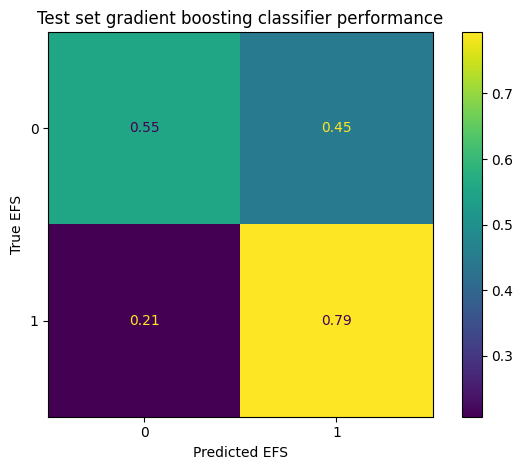

Precision: 0.676
Recall: 0.793


Binary target encoded



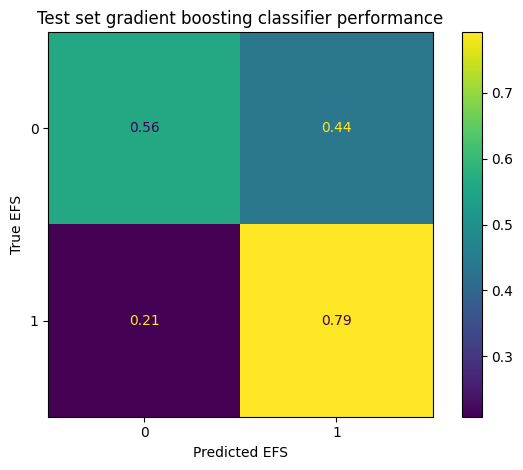

Precision: 0.679
Recall: 0.792


Continuous target encoded



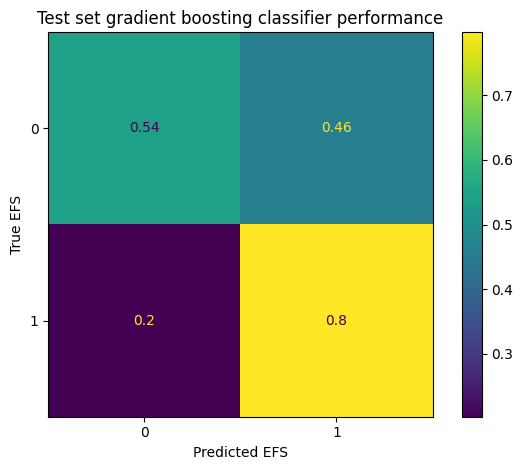

Precision: 0.672
Recall: 0.798



In [5]:
if train_tree == True:

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        data_df=pd.read_parquet(data_file)

        # Drop the unencoded race_group
        data_df.drop('race_group', axis=1, inplace=True)

        # Train test split
        training_df, testing_df=train_test_split(data_df, test_size=0.3, random_state=315)

        # Remove the labels
        training_labels_df=training_df[['efs', 'efs_time']].copy()
        training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
        testing_labels_df=testing_df[['efs', 'efs_time']].copy()
        testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

        tree_model=GradientBoostingClassifier(random_state=315)
        tree_model.fit(training_features_df, training_labels_df['efs'])

        predictions=tree_model.predict(testing_features_df)

        # Calculate precision and recall
        precision=precision_score(testing_labels_df['efs'], predictions)
        recall=recall_score(testing_labels_df['efs'], predictions)

        # Plot the confusion matrix
        cm=confusion_matrix(testing_labels_df['efs'], predictions, normalize='true')
        cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', 'EFS 1'])
        _=cm_disp.plot()

        print(f'\n{dataset}\n')

        plt.title('Test set gradient boosting classifier performance')
        plt.xlabel('Predicted EFS')
        plt.ylabel('True EFS')
        plt.tight_layout()
        plt.show()

        print(f'Precision: {precision:.3f}')
        print(f'Recall: {recall:.3f}\n')

### 3.2. Neural network

In [ ]:
l1=0.002
l2=0.0002
learning_rate=0.00001

In [ ]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

if train_nn == True:

    # Set the weight initializer function
    initializer=GlorotUniform(seed=315)

    # Set-up the L1L2 for the dense layers
    regularizer=L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    nn_model=Sequential([
        Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(256, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(128, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(64, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(32, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(16, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    nn_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[Precision(name='precision'), Recall(name='recall')]
    )

    # Calculate class weighting
    pos_examples=sum(training_labels_df['efs'])
    neg_examples=len(training_labels_df['efs']) - pos_examples
    neg_class_weight=(1 / neg_examples) * (len(training_labels_df['efs']) / 2.0)
    pos_class_weight=(1 / pos_examples) * (len(training_labels_df['efs']) / 2.0)

    # Do the training run
    training_results=nn_model.fit(
        training_features_df,
        training_labels_df['efs'],
        batch_size=256,
        validation_split=0.25,
        epochs=5000,
        # steps_per_epoch=steps_per_epoch,
        # validation_steps=validation_steps,
        verbose=True,
        class_weight={0: neg_class_weight, 1: pos_class_weight}
    )

In [ ]:
if train_nn == True:
    
    # Set-up a 1x2 figure for binary cross-entropy, precision & recall
    fig, axs=plt.subplots(1,3, figsize=(12,3))

    # Add the main title
    fig.suptitle('Classifier training curves', size='large')

    axs[0].set_title('Binary cross-entropy')
    axs[0].plot(training_results.history['loss'], label='Training')
    axs[0].plot(training_results.history['val_loss'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary cross-entropy')
    axs[0].legend(loc='upper left')

    axs[1].set_title('Precision')
    axs[1].plot(training_results.history['precision'])
    axs[1].plot(training_results.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision')

    axs[2].set_title('Recall')
    axs[2].plot(training_results.history['recall'])
    axs[2].plot(training_results.history['val_recall'])
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Recall')

    # Show the plot
    plt.tight_layout()

In [ ]:
if train_nn == True:
    
    predictions=nn_model.predict(testing_features_df)
    calls=list(np.where(np.array(predictions) > 0.5, 1, 0))

    # Calculate precision and recall
    precision=precision_score(testing_labels_df['efs'], calls)
    recall=recall_score(testing_labels_df['efs'], calls)

    # Plot the confusion matrix
    cm=confusion_matrix(testing_labels_df['efs'], calls, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', 'EFS 1'])
    _=cm_disp.plot()

    plt.title('Test set gradient boosting classifier performance')
    plt.xlabel('Predicted EFS')
    plt.ylabel('True EFS')
    plt.tight_layout()
    plt.show()

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}\n')